# Prepare data for fuzzy system

1. Import meter readings -> UK-DALE -> house 1 -> 2013 + select appliances (from Kitchen and Lounge)
3. Evaluate data granularity to select aggregation of data (original: meter readings every 6 second)
4. Create aggregated datasets for 1 min readings
5. Import spot prices (east Norway -> 2024)
6. Join meter readings and spot prices on time
7. Export to CSV-file in `data/ folder

### 1. Import meter readings and select appliances from original data

In [37]:
import pandas as pd, os

# path to UK-DALE dataset
house1_dir = "data/preprocessed_data/ukdale/house_1"

# connect meter readings with metadata (appliances)
labels = pd.read_csv(os.path.join(house1_dir, "labels.dat"), sep=" ", names=["channel", "appliance"], index_col=0)
labels = labels["appliance"].to_dict()

# select cols from original dataset - appliances in KITCHEN and LOUNGE
selected = list(["amp_livingroom", "DAB_radio_livingroom", "htpc", "iPad_charger", "livingroom_lamp_tv", "livingroom_s_lamp", "livingroom_s_lamp2", "subwoofer_livingroom", "tv", "breadmaker", "coffee_machine", "dishwasher", "fridge", "gas_oven", "kettle", "kitchen_dt_lamp", "kitchen_lamp2", "kitchen_lights", "kitchen_phone&stereo", "kitchen_radio", "microwave", "toaster"])


### 2. Evaluate data granularity and peaks

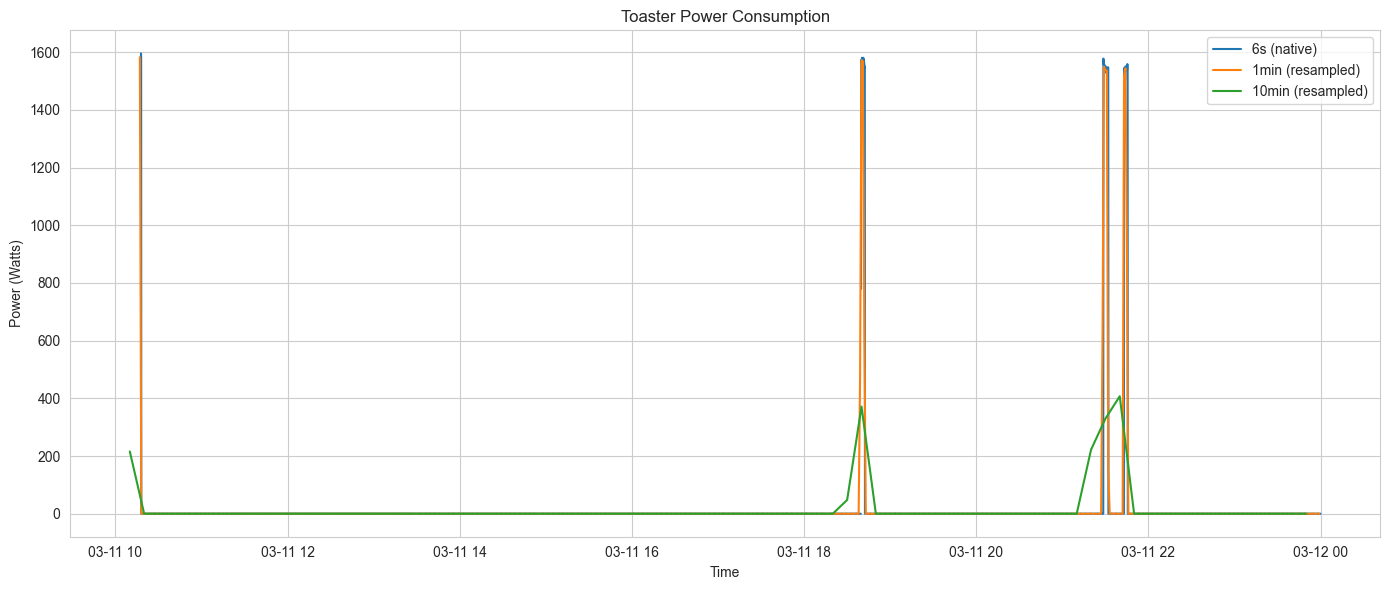

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import os

appliance_name = "toaster"               # pick appliance to evaluate

# load labels and find channel
labels = pd.read_csv(os.path.join(house1_dir, "labels.dat"),
                     sep=" ", names=["channel", "appliance"], index_col=0)
channel = labels[labels["appliance"] == appliance_name].index[0]
file_path = os.path.join(house1_dir, f"channel_{channel}.dat")

# load data
df = pd.read_csv(file_path, sep=" ", names=["timestamp", "power"], dtype={0: "int64", 1: "float32"})
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)

# pick sample period in the data
sample = df.loc["2013-03-11"]

# resample at multiple rates
df_6s = sample.resample("6s").mean()            # original granularity
df_1min = sample.resample("1min").mean()
df_10min = sample.resample("10min").mean()

# line plot:
plt.figure(figsize=(14, 6))
plt.plot(df_6s.index, df_6s["power"], label="6s (native)")
plt.plot(df_1min.index, df_1min["power"], label="1min (resampled)")
plt.plot(df_10min.index, df_10min["power"], label="10min (resampled)")
plt.title(f"{appliance_name.capitalize()} Power Consumption")
plt.xlabel("Time")
plt.ylabel("Power (Watts)")
plt.legend()
plt.tight_layout()
plt.show()


**Verdict:** The 10min means cuts the peaks to the point where the appliance might not be evaluated at "high" energy usage in the fuzzy logic. This can create an unrealistic representation. The 1min sample keeps the peak, while still reducing the sample size significantly.
<br>
<br>
This might change when we get into the project, but to keep a close to original shape of the data, we export the aggregated 1min interval data.

### 3. Create aggregated dataset with meter readings and clean

In [38]:
import pandas as pd, os

# select start and end of meter readings
year = 2013
start = pd.Timestamp(f"{year}-01-01")
end = pd.Timestamp(f"{year}-12-31 23:59:59")

# aggregated 1min intervals of meter readings (based on mean)
merged_1min = None

# extract data from all selected appliances for 1 min intervals
for ch, name in labels.items():
    if name in selected:
        fp = os.path.join(house1_dir, f"channel_{ch}.dat")
        if os.path.exists(fp):
            print(f"Loading {name} from {fp}")
            df = pd.read_csv(fp, sep=" ", names=["timestamp", name], dtype={0: 'int64', 1: 'float32'})
            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
            df = df[(df["timestamp"] >= start) & (df["timestamp"] <= end)]
            df.set_index("timestamp", inplace=True)

            # downsample to 1-minute intervals
            df_1min = df.resample("1min").mean()

            merged_1min = df_1min if merged_1min is None else merged_1min.join(df_1min, how="outer")



Loading dishwasher from data/preprocessed_data/ukdale/house_1/channel_6.dat
Loading tv from data/preprocessed_data/ukdale/house_1/channel_7.dat
Loading kitchen_lights from data/preprocessed_data/ukdale/house_1/channel_8.dat
Loading htpc from data/preprocessed_data/ukdale/house_1/channel_9.dat
Loading kettle from data/preprocessed_data/ukdale/house_1/channel_10.dat
Loading toaster from data/preprocessed_data/ukdale/house_1/channel_11.dat
Loading fridge from data/preprocessed_data/ukdale/house_1/channel_12.dat
Loading microwave from data/preprocessed_data/ukdale/house_1/channel_13.dat
Loading breadmaker from data/preprocessed_data/ukdale/house_1/channel_16.dat
Loading amp_livingroom from data/preprocessed_data/ukdale/house_1/channel_17.dat
Loading livingroom_s_lamp from data/preprocessed_data/ukdale/house_1/channel_19.dat
Loading kitchen_dt_lamp from data/preprocessed_data/ukdale/house_1/channel_23.dat
Loading livingroom_s_lamp2 from data/preprocessed_data/ukdale/house_1/channel_26.dat
L

#### Tidy df

In [91]:
# replace NaN with 0
merged_1min = merged_1min.fillna(0)

# add column for 'month', 'day' and 'hour' to prepare for join with spot prices
merged_1min['month'] = merged_1min.index.month
merged_1min['day'] = merged_1min.index.day
merged_1min['hour'] = merged_1min.index.hour

merged_1min

,dishwasher,tv,kitchen_lights,htpc,kettle,toaster,fridge,microwave,breadmaker,amp_livingroom,...,livingroom_lamp_tv,DAB_radio_livingroom,kitchen_lamp2,kitchen_phone&stereo,coffee_machine,kitchen_radio,gas_oven,hour,month,day
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.0,94.000000,0.0,69.199997,1.0,0.0,88.800003,1.0,0.0,23.200001,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1
2013-01-01 00:01:00,1.0,108.099998,0.0,69.400002,1.0,0.0,88.599998,1.0,0.0,23.100000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1
2013-01-01 00:02:00,1.0,101.555557,0.0,69.444443,1.0,0.0,88.599998,1.0,0.0,23.111111,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1
2013-01-01 00:03:00,1.0,97.900002,0.0,69.699997,1.0,0.0,88.888885,1.0,0.0,23.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1
2013-01-01 00:04:00,1.0,91.900002,0.0,69.199997,1.0,0.0,88.800003,1.0,0.0,23.200001,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 23:55:00,1.0,1.000000,0.0,64.666664,1.0,1.0,0.000000,1.0,0.0,23.444445,...,13.0,0.0,18.000000,1.0,0.888889,1.0,3.0,23,12,31
2013-12-31 23:56:00,1.0,1.000000,0.0,67.250000,1.0,1.0,0.000000,1.0,0.0,23.250000,...,13.0,0.0,18.111111,1.0,0.111111,1.0,3.0,23,12,31
2013-12-31 23:57:00,1.0,1.000000,0.0,64.625000,1.0,1.0,0.000000,1.0,0.0,23.000000,...,13.0,0.0,18.000000,1.0,0.375000,1.0,3.0,23,12,31


### 4. Import spot prices -> East Norway 2024

In [86]:
el_prices_2024 = "data/preprocessed_data/spotpriser_2024.csv"
el_prices_2024 = pd.read_csv(el_prices_2024, sep=";")

# clean date and time
# remove "Kl. " and split hour range "00-01"
el_prices_2024["timestamp_clean"] = (
    el_prices_2024["timestamp"]
    .str.replace("Kl. ", "", regex=False)
    .str.replace(" ", "T")               # make ISO-like
    .str.replace("-", ":", regex=False)  # "00-01" -> "00:01" temporarily
)

# extract only the starting hour (before '-')
el_prices_2024["timestamp_clean"] = (
    el_prices_2024["timestamp"]
    .str.replace("Kl. ", "", regex=False)
    .str.extract(r"(\d{4}-\d{2}-\d{2})\s+(\d{2})-\d{2}")
    .apply(lambda x: f"{x[0]} {x[1]}:00", axis=1)
)
el_prices_2024["timestamp"] = pd.to_datetime(
    el_prices_2024["timestamp_clean"],
    format="%Y-%m-%d %H:%M"
)

# remove helper column and index clean timestamp
el_prices_2024 = el_prices_2024.drop(columns=["timestamp_clean"])
el_prices_2024.set_index("timestamp", inplace=True)

el_prices_2024.head()

,NO1,NO2,NO3,NO4,NO5
timestamp,,,,,
2024-01-01 00:00:00,"0,75419","0,75419","0,41446","0,33157","0,77690"
2024-01-01 01:00:00,"0,68675","0,68675","0,39904","0,31923","0,74886"
2024-01-01 02:00:00,"0,38488","0,38488","0,37380","0,29904","0,72951"
2024-01-01 03:00:00,"0,34324","0,34324","0,34324","0,27459","0,71143"
2024-01-01 04:00:00,"0,33665","0,33665","0,33665","0,26932","0,69881"


In [87]:
# add column for 'month', 'day' and 'hour' to prepare for join with spot prices
el_prices_2024['month'] = el_prices_2024.index.month
el_prices_2024['day'] = el_prices_2024.index.day
el_prices_2024['hour'] = el_prices_2024.index.hour

el_prices_2024.head()

,NO1,NO2,NO3,NO4,NO5,month,day,hour
timestamp,,,,,,,,
2024-01-01 00:00:00,"0,75419","0,75419","0,41446","0,33157","0,77690",1,1,0
2024-01-01 01:00:00,"0,68675","0,68675","0,39904","0,31923","0,74886",1,1,1
2024-01-01 02:00:00,"0,38488","0,38488","0,37380","0,29904","0,72951",1,1,2
2024-01-01 03:00:00,"0,34324","0,34324","0,34324","0,27459","0,71143",1,1,3
2024-01-01 04:00:00,"0,33665","0,33665","0,33665","0,26932","0,69881",1,1,4


In [104]:
# create new df with only relevant columns ->['NO1', 'hour'] -> NO1 = East Norway
spot_prices_clean = el_prices_2024[['NO1', 'hour', 'month', 'day']].rename(columns={'NO1': 'spot_price'})

# make 'spot_price' float
spot_prices_clean['spot_price'] = (
    spot_prices_clean['spot_price']
    .astype(str)               # ensure it is string type
    .str.replace(',', '.', regex=False)
    .astype(float)
)

In [105]:
# check for duplicates from end of daylight savings
dupes = spot_prices_clean.duplicated(subset=['month', 'day', 'hour'], keep=False)
spot_prices_clean[dupes].sort_values(['month', 'day', 'hour'])

# drop duplicates
spot_prices_clean = spot_prices_clean.drop_duplicates(subset=['month', 'day', 'hour'], keep='first')

### 5. Join meter readings with spot prices in complete table

Join left to keep all rows of meter readings.

In [108]:
merged_full = merged_1min.merge(
    spot_prices_clean[['month', 'day', 'hour', 'spot_price']],
    on=['month', 'day', 'hour'],
    how='left'
)

# restore timestamp index from merged_1min
merged_full.index = merged_1min.index

merged_full

,dishwasher,tv,kitchen_lights,htpc,kettle,toaster,fridge,microwave,breadmaker,amp_livingroom,...,DAB_radio_livingroom,kitchen_lamp2,kitchen_phone&stereo,coffee_machine,kitchen_radio,gas_oven,hour,month,day,spot_price
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.0,94.000000,0.0,69.199997,1.0,0.0,88.800003,1.0,0.0,23.200001,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1,0.75419
2013-01-01 00:01:00,1.0,108.099998,0.0,69.400002,1.0,0.0,88.599998,1.0,0.0,23.100000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1,0.75419
2013-01-01 00:02:00,1.0,101.555557,0.0,69.444443,1.0,0.0,88.599998,1.0,0.0,23.111111,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1,0.75419
2013-01-01 00:03:00,1.0,97.900002,0.0,69.699997,1.0,0.0,88.888885,1.0,0.0,23.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1,0.75419
2013-01-01 00:04:00,1.0,91.900002,0.0,69.199997,1.0,0.0,88.800003,1.0,0.0,23.200001,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0,1,1,0.75419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 23:55:00,1.0,1.000000,0.0,64.666664,1.0,1.0,0.000000,1.0,0.0,23.444445,...,0.0,18.000000,1.0,0.888889,1.0,3.0,23,12,31,0.32509
2013-12-31 23:56:00,1.0,1.000000,0.0,67.250000,1.0,1.0,0.000000,1.0,0.0,23.250000,...,0.0,18.111111,1.0,0.111111,1.0,3.0,23,12,31,0.32509
2013-12-31 23:57:00,1.0,1.000000,0.0,64.625000,1.0,1.0,0.000000,1.0,0.0,23.000000,...,0.0,18.000000,1.0,0.375000,1.0,3.0,23,12,31,0.32509


### 6. Export CSV

In [109]:
merged_full.to_csv(
    "data/house1_clean_with_elprices.csv", float_format="%.3f")